In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import jax
from jax import vmap, jit
import jax.numpy as jnp
import jax.random as jrandom
import gpjax as gpx
import numpy as np
import pandas as pd
from functools import partial
import os
import scipy.stats.qmc as qmc

jax.config.update("jax_enable_x64", True)

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


# Multifidelity Gaussian process surrogates

Oftentimes, we have multiple different models for the same phenomenon, where each model has a different level of fidelity. For example, a ***high***-fidelity model could be a simulation that takes weeks/months to evaluate or a labor-intensive laboratory experiment that requires specific expertise. We might only have a handful of evaluations from the high-fidelity model. On the other hand, a ***low***-fidelity model typically involves simpler physics or coarser discretizations, and may only take minutes/hours to evaluate. We typically have much more low-fidelity data. 

It would be nice if we could somehow use the low-fidelity data to inform a surrogate for the high-fidelity model. [Kennedy and O'Hagan (2000)](https://academic.oup.com/biomet/article/87/1/1/221217) demonstrate how to do this via a **multi-fidelity Gaussian process.** Let's show how it works with a synthetic example.

## Example 1: Multi-fidelity regression of a synthetic function

Suppose we have a ***high***-fidelity model $f_h$ and a ***low***-fidelity model $f_\ell$ of some phemonenon, given by

$$
\begin{align*}
    f_h(\mathbf{x}) &= \frac{1}{2} \sin\left( \frac{5}{2} x_1 + \frac{2}{3} x_2 \right)^2 + \frac{2}{3} e^{-x_1 (x_2 - \frac{1}{2})^2} \cos(4x_1 + x_2)^2 \\
    f_\ell(\mathbf{x}) &= 1.5 f_h(\mathbf{x}) + \frac{1}{3} \sin(x_1 + x_2) + \frac{1}{2} e^{-x_1} \sin(x_1 + 7x_2).
\end{align*}
$$

We want to create a surrogate for $f_h$.

### Datasets

Suppose we evaluate $f_h$ at a limited number of points $\mathbf{X}_h$:

$$
\begin{align*}
    \mathbf{X}_h &\equiv \begin{bmatrix} \mathbf{x}_{h,1} \\ \vdots \\ \mathbf{x}_{h,N_h} \end{bmatrix} &\in \mathbb{R}^{N_h \times d} \\
    \mathbf{y}_h &\equiv \begin{bmatrix} y_{h,1} \\ \vdots \\ y_{h,N_h} \end{bmatrix} 
    \equiv \begin{bmatrix} f_h(\mathbf{x}_{h,1}) \\ \vdots \\ f_h(\mathbf{x}_{h,N_h}) \end{bmatrix} &\in \mathbb{R}^{N_h}
\end{align*}
$$

where $N_h$ is the number of evaluations, $d$ is the input dimension, and $\mathbf{x}_{h,i} \in \mathbb{R}^d$ and $y_{h,i} \in \mathbb{R}$ are the input and output for the $i^\text{th}$ evaluation, respectively. 
This is our high-fidelity data.

Suppose we also evaluate $f_\ell$ at the same points $\mathbf{X}_h$ ***and*** at some different points $\mathbf{X}_\ell' \in \mathbb{R}^{N_\ell' \times d}$:

$$
\begin{align*}
    \mathbf{y}^{\text{same}}_\ell &\equiv \begin{bmatrix} f_\ell(\mathbf{x}_{h,1}) \\ \vdots \\ f_\ell(\mathbf{x}_{h,N_h}) \end{bmatrix} &\in \mathbb{R}^{N_h} \\
    \mathbf{y}^{\text{diff}}_\ell &\equiv \begin{bmatrix} f_\ell(\mathbf{x}_{\ell,1}) \\ \vdots \\ f_\ell(\mathbf{x}_{\ell,N_\ell'}) \end{bmatrix} &\in \mathbb{R}^{N_\ell'}
\end{align*}
$$

This is our low fidelity data.
Let's generate the data and visualize the functions.

In [2]:
N_LOW_FIDELITY = 50
N_HIGH_FIDELITY = 8
N_TEST = 100
SEED = 1

def high_fidelity_model(x):
    x1, x2 = x[0], x[1]
    return 1/2*jnp.sin(5/2*x1 + 2/3*x2)**2 + 2/3*jnp.exp(-x1*(x2 - 0.5)**2)*jnp.cos(4*x1 + x2)**2

def low_fidelity_model(x):
    x1, x2 = x[0], x[1]
    return 2.5*high_fidelity_model(x) + 1/3*( jnp.sin(x1 + x2) + 1/2*jnp.exp(-x1)*jnp.sin(x1 + 7*x2) )

def generate_synthetic_data(n_l, n_h, n_test, key=None):
    """Returns datasets necessary for training and testing a multi-fidelity GP."""

    # Train data
    x_train_l_only = jnp.array(qmc.LatinHypercube(2).random(n=n_l - n_h))
    x_train_h = jnp.array(qmc.LatinHypercube(2).random(n_h))
    y_train_l_only = vmap(low_fidelity_model)(x_train_l_only)
    y_train_l_common = vmap(low_fidelity_model)(x_train_h)
    y_train_h = vmap(high_fidelity_model)(x_train_h)
    x_train_l = jnp.concatenate([x_train_l_only, x_train_h], axis=0)  # low fidelity inputs points should also include all the high fidelity input points
    y_train_l = jnp.concatenate([y_train_l_only, y_train_l_common], axis=0) 

    # Test data
    x_test = jrandom.uniform(key, (n_test, 2))
    y_test_l = vmap(low_fidelity_model)(x_test)
    y_test_h = vmap(high_fidelity_model)(x_test)

    # D_low_only = gpx.Dataset(x_train_l_only, y_train_l_only[:, None])
    D_low_common = gpx.Dataset(x_train_h, y_train_l_common[:, None])
    D_low = gpx.Dataset(x_train_l, y_train_l[:, None])
    D_high = gpx.Dataset(x_train_h, y_train_h[:, None])
    D_low_test = gpx.Dataset(x_test, y_test_l[:, None])
    D_high_test = gpx.Dataset(x_test, y_test_h[:, None])

    return D_low_common, D_low, D_high, D_low_test, D_high_test

key, subkey = jrandom.split(jrandom.PRNGKey(SEED))
D_low_common, D_low, D_high, D_low_test, D_high_test = generate_synthetic_data(N_LOW_FIDELITY, N_HIGH_FIDELITY, N_TEST, key=subkey)

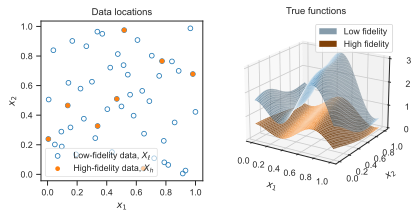

In [3]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(D_low.X[:,0], D_low.X[:, 1], label=r'Low-fidelity data, $X_\ell$', marker='o', facecolors='none', edgecolors='tab:blue')
ax.scatter(D_high.X[:,0], D_high.X[:, 1], label=r'High-fidelity data, $X_h$', marker='o', facecolors='tab:orange', edgecolors='none')
ax.set_aspect('equal')
ax.set_title('Data locations')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
leg = ax.legend()
leg.get_frame().set_alpha(0.6)

x1, x2 = jnp.linspace(0, 1, 100), jnp.linspace(0, 1, 100)
X1, X2 = jnp.meshgrid(x1, x2)
Y_low = vmap(low_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)
Y_high = vmap(high_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X1, X2, Y_low, label='Low fidelity', lw=0.1, alpha=0.5)
ax.plot_surface(X1, X2, Y_high, label='High fidelity', lw=0.1)
ax.view_init(elev=20, azim=-58)
ax.set_title('True functions')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend();

For ease of notation, let's group all the low-fidelity data together: 

$$
\begin{align*}
    \mathbf{X_\ell} &\equiv \begin{bmatrix} \mathbf{X}_h \\ \mathbf{X}_\ell' \end{bmatrix} &\in \mathbb{R}^{N_\ell \times d}  \\
    \mathbf{y_\ell} &\equiv \begin{bmatrix} \mathbf{y}^{\text{same}}_\ell \\ \mathbf{y}^{\text{diff}}_\ell \end{bmatrix} &\in \mathbb{R}^{N_\ell}
\end{align*}
$$

where $N_\ell = N_h + N_\ell'$ is the total number of low-fidelity simulations.

<!-- We now have low and high fidelity datasets $D_\ell \equiv ( \mathbf{x}_\ell, \mathbf{y}_\ell )$ and $D_h \equiv ( \mathbf{x}_h, \mathbf{y}_h )$, respectively. -->

<!-- For simplicity, assume we have low-fidelity data at every location where we have high-fidelity data, i.e., $\mathbf{x}_h \subset \mathbf{x}_\ell$. Let's generate the data for this synthetic example: -->

<!-- Our goal is to approximate the "***high***-fidelity" model $f_h$ with a multi-fidelity Gaussian process.

$$
f_h(\mathbf{x}) = \frac{1}{2} \sin\left( \frac{5}{2} x_1 + \frac{2}{3} x_2 \right)^2 + \frac{2}{3} e^{-x_1 (x_2 - \frac{1}{2})^2} \cos(4x_1 + x_2)^2
$$

given by
$$
f_\ell(\mathbf{x}) = 1.5 f_h(\mathbf{x}) + \frac{1}{3} \sin(x_1 + x_2) + \frac{1}{2} e^{-x_1} \sin(x_1 + 7x_2)
$$ -->

### Low-fidelity Gaussian process

We start by making a Gaussian process surrogate $\hat{f}_\ell$ using just the low-fidelity data $\mathcal{D}_\ell = (\mathbf{X}_\ell, \mathbf{y}_\ell)$: 

$$
\hat{f}_\ell(\cdot) \sim GP\Big(\mathbf{0}(\cdot), k(\cdot, \cdot)\Big) \\
$$

We just set the covariance kernel $k$ as a radial basis function (RBF) kernel
whose variance, $\sigma^2$, and lengthscale, $\ell_d$, are found by maximizing the marginal log likelihood, i.e.,

$$
\sigma^2, \ell_d = \arg\max_{\sigma^2, \ell_d} \log p(\mathbf{y}_\ell | \mathbf{X}_\ell, \sigma^2, \ell_d)
$$

<!-- $$
k(\mathbf{x}, \mathbf{x}') = \sigma^2 \exp\left( -\frac{1}{2} \sum_{d=1}^D \left( \frac{x_d - x'_d}{\ell_d} \right)^2 \right)
$$ --> 

Let's do this in GPJax:

In [4]:
# Construct low-fidelity GP
mean_low = gpx.mean_functions.Zero()
kernel_low = gpx.kernels.RBF(lengthscale=jnp.ones(2), variance=1.0)
prior_low = gpx.gps.Prior(mean_function=mean_low, kernel=kernel_low)
likelihood_low = gpx.likelihoods.Gaussian(
    num_datapoints=D_low.n, 
    obs_stddev=1.0,
)
posterior_low = prior_low * likelihood_low

# Loss function
negative_mll = lambda p, d: -gpx.objectives.conjugate_mll(p, d)

# Optimize low-fidelity hyperparameters
posterior_low, history_low = gpx.fit_scipy(
    model=posterior_low,
    objective=negative_mll,
    train_data=D_low,
    max_iters=1000
)

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


         Current function value: -115.180552
         Iterations: 50
         Function evaluations: 113
         Gradient evaluations: 101


/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Let's visualize the fit to the *low*-fidelity data with a parity plot:

In [5]:
def generate_predictive_dist(x, posterior, train_data):
    latent_dist = posterior.predict(x, train_data=train_data)
    return posterior.likelihood(latent_dist)

predictive_dist_low = generate_predictive_dist(D_low_test.X, posterior_low, D_low)
mean_low_test = predictive_dist_low.mean()
std_low_test = predictive_dist_low.stddev()

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


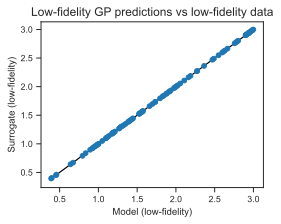

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
ax.errorbar(D_low_test.y, mean_low_test, yerr=2 * std_low_test, fmt="o")
ax.plot(D_low_test.y, D_low_test.y, "k--")
ax.set_xlabel("Model (low-fidelity)")
ax.set_ylabel("Surrogate (low-fidelity)")
ax.set_title(r"Low-fidelity GP predictions vs low-fidelity data", fontsize=12);

It looks good. Now onto multi-fidelity.

### Multi-fidelity Gaussian process

The idea behind the multi-fidelity GP is this: Do GP regression on the high-fidelity data, but **add a dimension to the input space which represents the output of the low-fidelity model**. 

More precisely, the multi-fidelity GP is

$$
\hat{f}_m  \sim GP\Big(\mathbf{0}(\cdot), k_m(\cdot, \cdot)\Big) \\
$$

where the multi-fidelity covariance kernel $k_m$ is

$$
\underbrace{k_m(\mathbf{x}, \mathbf{x}')}_{d\text{-dim kernel}}
\equiv k\bigg( ~ \underbrace{\left[\mathbf{x} \quad \hat{f}_\ell(\mathbf{x})\right]}_{\equiv \mathbf{x}^\text{aug}} ~ , ~~ \underbrace{\left[\mathbf{x}' \quad \hat{f}_\ell(\mathbf{x}')\right]}_{\equiv {\mathbf{x}^\text{aug}}'} ~ \bigg)
\equiv \underbrace{k \left( \mathbf{x}^\text{aug}, {\mathbf{x}^\text{aug}}' \right)}_{(d+1)\text{-dim kernel}}
$$

Note that $k_m$ itself has a Gaussian process $(\hat{f}_\ell)$ inside of it! This is how low-fidelity information is passed to $\hat{f}_m$. 
Intuitively, the multi-fidelity GP automatically "learns" how to correct the low-fidelity model's predictions.

Also, note that in GPJax we will actually implement the equivalent $(d+1)$-dimensional *augmented* GP

$$
\hat{f}_m^\text{aug}  \sim GP\Big(\mathbf{0}(\cdot), k(\cdot, \cdot)\Big) \\
$$

and train it on the data

$$
\begin{align}
    \mathbf{X}_m 
    &= [ 
        \underbrace{\mathbf{X}_h}_{\substack{\text{high-fidelity} \\ \text{input points}}} 
        \quad 
        \underbrace{\mathbf{y}^\text{same}_\ell}_{\substack{\text{low-fidelity model} \\ \text{evaluated at } \mathbf{X}_h}} 
    ] 
    &\in \mathbb{R}^{N_h \times d+1} \\
    \mathbf{y}_m 
    &= \underbrace{\mathbf{y}_h}_{\substack{\text{high-fidelity model} \\ \text{evaluated at } \mathbf{X}_h}}
    &\in \mathbb{R}^{N_h}.
\end{align}
$$

You can think of this as a form of *data augmentation* (we simply augment the high-fidelity dataset with some low-fidelity model evaluations at the same points).

Let's try this out. Here is a GP constructed with the new augmented dataset $\mathcal{D}_m = (\mathbf{X}_m$, $\mathbf{y}_m)$:

In [7]:
Xm = jnp.concatenate([D_high.X, D_low_common.y], axis=1)
ym = D_high.y
D_multi = gpx.Dataset(Xm, ym)

# Construct multi-fidelity GP
mean_multi = gpx.mean_functions.Zero()
kernel_multi = gpx.kernels.RBF(lengthscale=jnp.ones(3), variance=1.0)
prior_multi = gpx.gps.Prior(mean_function=mean_multi, kernel=kernel_multi)
likelihood_multi = gpx.likelihoods.Gaussian(
    num_datapoints=D_multi.n, 
    obs_stddev=1.0
)
posterior_multi = prior_multi * likelihood_multi

# Optimize multi-fidelity hyperparameters
posterior_multi, history_multi = gpx.fit_scipy(
    model=posterior_multi,
    objective=negative_mll,
    train_data=D_multi,
    max_iters=1000
)

Optimization terminated successfully.
         Current function value: -8.777617
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26


Note that this is now a 3D-input GP instead of a 2D-input GP (due to the augmented dimension).

### Sampling from the posterior

The next question is **how do we sample the posterior multi-fidelity GP $\hat{f}_m(\cdot) | \mathcal{D}_m$ at some test input $\mathbf{x}_\text{test}?$** Here is how:

1. First, sample the posterior low-fidelity GP:

$$
f_{\ell,\text{sample}}(\cdot) \sim \hat{f}_\ell(\cdot) | \mathcal{D}_\ell
$$ 

$~~~~~~~$ Then, evaluate at the test point: 

$$
y_{\ell,\text{test}}=f_{\ell,\text{sample}}(\mathbf{x}_\text{test})
$$

In [8]:
x_test = jnp.array([[0.5, 0.5]])
predictive_dist_low_test = generate_predictive_dist(x_test, posterior_low, D_low)
key, subkey = jrandom.split(key)
samples_low_test = predictive_dist_low_test.sample((), subkey)

2. Next, augment the input like $\mathbf{x}_\text{test}^\text{aug} = [ \mathbf{x}_\text{test} \quad y_{\ell,\text{test}} ]$.

In [9]:
x_augmented = jnp.concatenate([x_test, samples_low_test[:, None]], axis=-1)

3. Finally, sample the posterior multi-fidelity (augmented) GP:

$$
f_{m,\text{sample}}(\cdot) \sim \hat{f}_m^\text{aug}(\cdot) | \mathcal{D}_m
$$

$~~~~~~~$ And evaluate at the (augmented) test point:

$$
y_{m,\text{test}}=f_{m,\text{sample}}(\mathbf{x}_\text{test}^\text{aug})
$$

In [10]:
predictive_dist_multi_test = generate_predictive_dist(x_augmented, posterior_multi, D_multi)
key, subkey = jrandom.split(key)
samples_multi_test = predictive_dist_multi_test.sample((), key)

print(f'The sample is:     {samples_multi_test.squeeze():.4f}')
print(f'The true value is: {high_fidelity_model(x_test[0]):.4f}')

The sample is:     0.9205
The true value is: 0.9278


And that's it! We now know how to construct and sample a multi-fidelity GP surrogate. 
Next, we'll check our surrogate's accuracy. 

Before we do that, however, let's train a vanilla GP on the high-fidelity data for comparison:

In [11]:
# Construct high-fidelity GP
mean_high = gpx.mean_functions.Zero()
kernel_high = gpx.kernels.RBF(lengthscale=jnp.ones(2), variance=1.0)
prior_high = gpx.gps.Prior(mean_function=mean_high, kernel=kernel_high)
likelihood_high = gpx.likelihoods.Gaussian(
    num_datapoints=D_high.n, 
    obs_stddev=1.0
)
posterior_high = prior_high * likelihood_high

# Optimize multi-fidelity hyperparameters
posterior_high, history_high = gpx.fit_scipy(
    model=posterior_high,
    objective=negative_mll,
    train_data=D_high,
    max_iters=1000
)

Optimization terminated successfully.
         Current function value: 2.006980
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34


Let's also wrap the sampling code into functions (for organization):

In [12]:
def sample_multi_fidelity_gp(
    X, 
    key, 
    num_samples,
    posterior_low=posterior_low, 
    posterior_multi=posterior_multi, 
    D_low=D_low,
    D_multi=D_multi
):
    """Sample from the multi-fidelity Gaussian process.
    
    Parameters
    ----------
    X : ndarray
        The test points.
    posterior_low : gpx.gps.Posterior
        The low-fidelity GP posterior.
    posterior_multi : gpx.gps.Posterior
        The multi-fidelity GP posterior.
    key : PRNGKey
        The random key.
    num_samples : int
        The number of samples to draw.
    D_low : gpx.Dataset
        The low-fidelity dataset.
    D_multi : gpx.Dataset
        The multi-fidelity dataset.

    Returns
    -------
    ndarray
        The samples from the multi-fidelity GP. The shape is (num_samples, num_test_points).
    """
    predictive_dist_low = generate_predictive_dist(X, posterior_low, D_low)
    samples_low_test = predictive_dist_low.sample((num_samples,), key)
    single_augment_fn = lambda yl: jnp.concatenate([X, yl[:, None]], axis=-1)
    x_aug = vmap(single_augment_fn)(samples_low_test)  # This is now shape (num_samples, num_test_points, d)
    x_aug_flat = x_aug.reshape(-1, X.shape[-1] + 1)  # This is now shape (num_samples*num_test_points, d)
    predictive_dist_multi = generate_predictive_dist(x_aug_flat, posterior_multi, D_multi)
    samples_multi_test = predictive_dist_multi.sample((), key).reshape(num_samples, X.shape[0])
    return samples_multi_test

def sample_vanilla_gp(
    X,
    key,
    num_samples,
    posterior,
    D
):
    """Sample from a vanilla GP.

    Parameters
    ----------
    X : ndarray
        The test points.
    key : PRNGKey
        The random key.
    num_samples : int
        The number of samples to draw.
    posterior : gpx.gps.Posterior
        The GP posterior.
    D : gpx.Dataset
        The dataset.
    """
    predictive_dist = generate_predictive_dist(X, posterior, D)
    samples = predictive_dist.sample((num_samples,), key)
    return samples

Now, we are ready to see how well the GPs predict the test data:

In [88]:
sample_high_fidelity_gp = partial(sample_vanilla_gp, posterior=posterior_high, D=D_high)
sample_low_fidelity_gp = partial(sample_vanilla_gp, posterior=posterior_low, D=D_low)
sample_multi_fidelity_gp = partial(sample_multi_fidelity_gp, posterior_low=posterior_low, posterior_multi=posterior_multi, D_low=D_low, D_multi=D_multi)

num_samples = 50
X_test = D_high_test.X
samples_low = sample_low_fidelity_gp(X_test, key, num_samples)
samples_high = sample_high_fidelity_gp(X_test, key, num_samples)
samples_multi = sample_multi_fidelity_gp(X_test, key, num_samples)

mean_low_test = samples_low.mean(axis=0)
std_low_test = samples_low.std(axis=0)
mean_high_test = samples_high.mean(axis=0)
std_high_test = samples_high.std(axis=0)
mean_multi_test = samples_multi.mean(axis=0)
std_multi_test = samples_multi.std(axis=0)

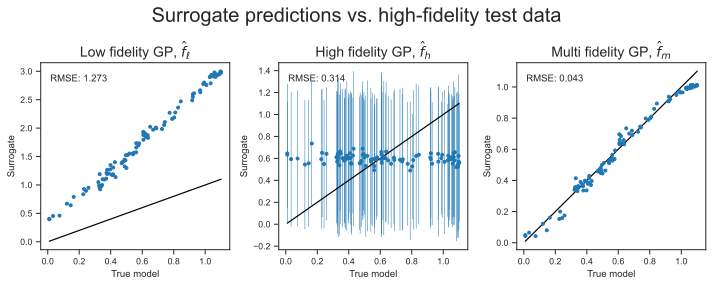

In [104]:
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

# Parity plot - add uncertainty on predictions using whiskers
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)
fig.suptitle("Surrogate predictions vs. high-fidelity test data", fontsize=20)
ax[0].errorbar(D_high_test.y, mean_low_test, yerr=2 * std_low_test, fmt="o", markersize=3, lw=0.5)
ax[0].plot(D_high_test.y, D_high_test.y, "k--")
ax[0].set_xlabel("True model")
ax[0].set_ylabel("Surrogate")
ax[0].set_title(r"Low fidelity GP, $\hat{f}_\ell$", fontsize=14)
ax[0].annotate(f"RMSE: {rmse(D_high_test.y.squeeze(-1), mean_low_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[1].errorbar(D_high_test.y, mean_high_test, yerr=2 * std_high_test, fmt="o", markersize=3, lw=0.5)
ax[1].plot(D_high_test.y, D_high_test.y, "k--")
ax[1].set_xlabel("True model")
ax[1].set_ylabel("Surrogate")
ax[1].set_title(r"High fidelity GP, $\hat{f}_h$", fontsize=14)
ax[1].annotate(f"RMSE: {rmse(D_high_test.y.squeeze(-1), mean_high_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[2].errorbar(D_high_test.y, mean_multi_test, yerr=2 * std_multi_test, fmt="o", markersize=3, lw=0.5)
ax[2].plot(D_high_test.y, D_high_test.y, "k--")
ax[2].set_xlabel("True model")
ax[2].set_ylabel("Surrogate")
ax[2].set_title(r"Multi fidelity GP, $\hat{f}_m$", fontsize=14)
ax[2].annotate(f"RMSE: {rmse(D_high_test.y.squeeze(-1), mean_multi_test):.3f}", xy=(0.05, 0.9), xycoords='axes fraction');

The multi-fidelity GP has the most accurate predictions. Let's visualize the mean predictive surface against the ground truth:

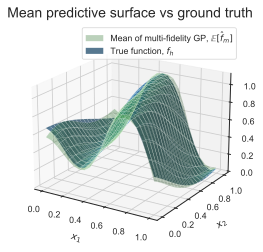

In [15]:
# Surface plot
x1, x2 = jnp.linspace(0, 1, 20), jnp.linspace(0, 1, 20)
X1, X2 = jnp.meshgrid(x1, x2)
X_plt = jnp.stack([X1.ravel(), X2.ravel()], axis=-1)
Y_high_plt = vmap(high_fidelity_model)(X_plt).reshape(X1.shape)
num_samples = 20
mean_multi_plt = sample_multi_fidelity_gp(X_plt, key, num_samples).mean(axis=0).reshape(X1.shape)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, mean_multi_plt, label=r'Mean of multi-fidelity GP, $\mathbb{E}[\hat{f}_m]$', color='tab:green', lw=0.1, alpha=0.3)
ax.plot_surface(X1, X2, Y_high_plt, label=r'True function, $f_h$', color='tab:blue', lw=0.1, alpha=0.7)
ax.view_init(elev=20, azim=-58)
ax.set_title('Mean predictive surface vs ground truth', fontsize=14)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend();

The surfaces are basically right on top of each other! Let's take a closer look at a vertical "slice" of the surface plot. Fix $x_2=0.5$, and vary $x_1$ along the $x$-axis:

In [86]:
# Slice plot
x1_slice = jnp.linspace(0, 1, 40)
x2_slice = jnp.full_like(x1_slice, 0.5)

X_slice = jnp.stack([x1_slice, x2_slice], axis=-1)
num_samples = 120
samples_low = sample_low_fidelity_gp(X_slice, key, num_samples)
samples_high = sample_high_fidelity_gp(X_slice, key, num_samples)
samples_multi = sample_multi_fidelity_gp(X_slice, key, num_samples)

mean_low_slice = samples_low.mean(axis=0)
std_low_slice = samples_low.std(axis=0)
mean_high_slice = samples_high.mean(axis=0)
std_high_slice = samples_high.std(axis=0)
mean_multi_slice = samples_multi.mean(axis=0)
std_multi_slice = samples_multi.std(axis=0)

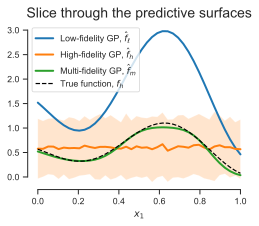

In [87]:
fig, ax = plt.subplots(figsize=(4,3))
ax.set_title("Slice through the predictive surfaces", fontsize=14)
ax.plot(x1_slice, mean_low_slice, label=r"Low-fidelity GP, $\hat{f}_\ell$", lw=2)
ax.fill_between(x1_slice, mean_low_slice - 2 * std_low_slice, mean_low_slice + 2 * std_low_slice, alpha=0.2)
ax.plot(x1_slice, mean_high_slice, label=r"High-fidelity GP, $\hat{f}_h$", lw=2)
ax.fill_between(x1_slice, mean_high_slice - 2 * std_high_slice, mean_high_slice + 2 * std_high_slice, alpha=0.2)
ax.plot(x1_slice, mean_multi_slice, label=r"Multi-fidelity GP, $\hat{f}_m$", lw=2)
ax.fill_between(x1_slice, mean_multi_slice - 2 * std_multi_slice, mean_multi_slice + 2 * std_multi_slice, alpha=0.2)
ax.plot(x1_slice, vmap(high_fidelity_model)(X_slice), label=r"True function, $f_h$", linestyle="--", color="black")
ax.set_xlabel(r'$x_1$')
ax.legend()
sns.despine(trim=True)

Again, the multi-fidelity GP $\hat{f}_m$ approximates the high-fidelity model $f_h$ very well! This is a significant improvement over naively fitting to the high-fidelity data alone.

### Questions

- Decrease `N_LOW_FIDELITY`. How does the multi-fidelity GP $\hat{f}_m$ perform with less low-fidelity data?
- Decrease `N_HIGH_FIDELITY`. How does multi-fidelity GP $\hat{f}_m$ perform with less high-fidelity data?
- Increase `N_HIGH_FIDELITY`. At what point is the high-fidelity-only GP $\hat{f}_h$ just as good as the multi-fidelity GP $\hat{f}_m$?
- Add more terms (sin/cos, exponential, quadratic, or whetever you want) to `low_fidelity_model`. How different can the low-fidelity model $f_\ell$ be from the high-fidelity model $f_h$ and still get a good surrogate $\hat{f}_m$?

## Example 2: Stochastic incompressible flow past a cylinder

This example is taken from [Perdikaris et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/). Suppose you have a flow past a cylinder, subject to random inflow boundary conditions of the form

$$
U_\infty(\sigma_1, \sigma_2; \xi_1, \xi_2) = 1 + \sigma_1 \sin\left(\frac{\pi y}{9}\right) + \sigma_2 \left[\xi_1 \sin\left(\frac{\pi y}{9}\right) + \xi_2 \cos\left( \frac{\pi y}{9} \right) \right]
$$

where $\mathbf{x} \equiv (\sigma_1, \sigma_2)$ are controllable design variables representing the amplitude and skewness of the inflow noise, and $\xi \equiv (\xi_1, \xi_2)$ are standard Gaussian random variables. 
Let $C_\text{BP}$ be the base pressure coefficient at the rear of the cylinder (see figure below).

![flow_past_cylinder](flow_past_cylinder.jpg)

Figure 9 from [Perdikaris et al. (2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/). The left figure shows the spatial discretization used for CFD, while the right figure shows the quantity of interest (i.e., the base pressure coefficient $C_\text{BP}$).

### Quantity of interest: Superquantile risk of base pressure coefficient

Note that for each inflow condition $\mathbf{x}$, we will get a distribution for $C_\text{BP}$. 
Our quantity of interest (QOI) is the mean of the upper 40% of this distribution, also known as the *superquantile risk* and denoted as $\mathcal{R}_{0.6}[C_\text{BP}]$. 
It's kind of like an expectation that places more weight on "risker" outcomes.
Minimizing the superquantile risk, therefore, translates to finding a *risk-averse* design, since it penalizing inflows based on their 40% worst-case scenarios for $C_\text{BP}.$

Computing the risk, however, is expensive&mdash;evaluating the risk once requires many CFD simulations.
Our goal therefore is to somehow speed up evaluation of $\mathcal{R}_{0.6}[C_\text{BP}](\mathbf{x})$.

### Datasets: Probabilistic collocation (high-fidelity) and Monte Carlo (low-fidelity)

As described in the paper, there are two different models that approximate $\mathcal{R}_{0.6}[C_\text{BP}]$. 
For some input $\mathbf{x}$, the **cheap low-fidelity** model $f_\ell$ uses coarse Monte Carlo (MC) estimation, while the **expensive high-fidelity** model $f_h$ uses the more accurate (but in this case ~16 times slower) probabilistic collocation method (PCM). 
As in example 1, we have many evaluations of $f_\ell$ and only a few of $f_h$. 
And we want to approximate $f_h$. 
This is a classic setup for multi-fidelity GP surrogate modeling. 
Let's do it.

First, import and visualize the data:
<!-- ```
# This is the data preprocessing script. It just gets the data into a format convenient for this notebook.pd
# It requires the supplementary data folder rspa20150018supp4 from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4528652/

import pandas as pd
import numpy as np
import os

X_pcm = pd.read_table('rspa20150018supp4/rspa-2015-0018-File003.dat', header=None, delimiter='  ')
y_pcm = pd.read_table('rspa20150018supp4/rspa-2015-0018-File006.dat', header=None, delimiter='  ')

X_mc = pd.read_table('rspa20150018supp4/rspa-2015-0018-File004.dat', header=None, delimiter='  ')
y_mc = pd.read_table('rspa20150018supp4/rspa-2015-0018-File007.dat', header=None, delimiter='  ')

Xy_pcm = pd.concat([X_pcm, y_pcm], axis=1)
Xy_pcm.columns = ['x1', 'x2', 'y']

Xy_mc = pd.concat([X_mc, y_mc], axis=1)
Xy_mc.columns = ['x1', 'x2', 'y']

ind = jrandom.choice(key=jrandom.PRNGKey(2), a=jnp.arange(Xy_pcm.shape[0]), shape=(8,), replace=False)
Xy_high = Xy_pcm.loc[ind]

data_folder = 'mf_cylinder_flow_data'
os.makedirs(data_folder, exist_ok=True)
Xy_pcm.to_csv(os.path.join(data_folder, 'ground_truth.csv'), index=False)
Xy_pcm.loc[ind].to_csv(os.path.join(data_folder, 'high_fidelity_data.csv'), index=False)
Xy_mc.to_csv(os.path.join(data_folder, 'low_fidelity_data.csv'), index=False)
``` -->

In [18]:
data_folder = 'mf_cylinder_flow_data'

high_fid_data = pd.read_csv(os.path.join(data_folder, 'high_fidelity_data.csv'))
low_fid_data = pd.read_csv(os.path.join(data_folder, 'low_fidelity_data.csv'))
ground_truth = pd.read_csv(os.path.join(data_folder, 'ground_truth.csv'))

D_high_cyl = gpx.Dataset(high_fid_data[['x1', 'x2']].values, high_fid_data['y'].values[:, None])
D_low_cyl = gpx.Dataset(low_fid_data[['x1', 'x2']].values, low_fid_data['y'].values[:, None])
gt = ground_truth.values.reshape(21, 17, 3)

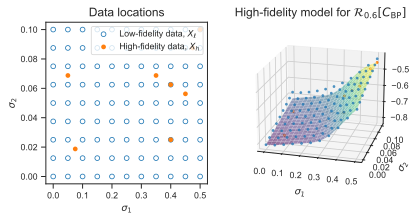

In [19]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(D_low_cyl.X[:,0], D_low_cyl.X[:, 1], label=r'Low-fidelity data, $X_\ell$', marker='o', facecolors='none', edgecolors='tab:blue')
ax.scatter(D_high_cyl.X[:,0], D_high_cyl.X[:, 1], label=r'High-fidelity data, $X_h$', marker='o', facecolors='tab:orange', edgecolors='none')
ax.set_aspect(5)
ax.set_title('Data locations', fontsize=12)
ax.set_xlabel(r'$\sigma_1$')
ax.set_ylabel(r'$\sigma_2$')
leg = ax.legend(loc='upper right')
leg.get_frame()

x1, x2 = jnp.linspace(0, 1, 100), jnp.linspace(0, 1, 100)
X1, X2 = jnp.meshgrid(x1, x2)
Y_low = vmap(low_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)
Y_high = vmap(high_fidelity_model)(jnp.stack([X1.ravel(), X2.ravel()], axis=-1)).reshape(X1.shape)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(gt[:,:,0], gt[:,:,1], gt[:,:,2], lw=0.1, cmap='viridis', alpha=0.5)
ax.scatter3D(D_low_cyl.X[:,0], D_low_cyl.X[:, 1], D_low_cyl.y[:, 0], s=4, label='Low fidelity', color='tab:blue', alpha=0.7)
ax.scatter3D(D_high_cyl.X[:,0], D_high_cyl.X[:, 1], D_high_cyl.y[:, 0], s=4, label='High fidelity', color='tab:orange', alpha=1)
ax.view_init(elev=20, azim=-75)
ax.set_title(r'High-fidelity model for $\mathcal{R}_{0.6}[C_\text{BP}]$', fontsize=12)
ax.set_xlabel(r'$\sigma_1$')
ax.set_ylabel(r'$\sigma_2$');

### Multi-fidelity Gaussian process for superquantile risk
<!-- for the risk, $\mathcal{R}_{0.6}[C_\text{BP}]$ -->

As before, we first construct the low-fidelity GP surrogate $\hat{f}_\ell$:

In [79]:
# Construct low-fidelity GP
mean_low_cyl = gpx.mean_functions.Zero()
kernel_low_cyl = gpx.kernels.RBF(lengthscale=jnp.ones(2), variance=0.01)
prior_low_cyl = gpx.gps.Prior(mean_function=mean_low_cyl, kernel=kernel_low_cyl)
likelihood_low_cyl = gpx.likelihoods.Gaussian(
    num_datapoints=D_low_cyl.n, 
    obs_stddev=0.0,
)
posterior_low_cyl = prior_low_cyl * likelihood_low_cyl

# Optimize low-fidelity hyperparameters
posterior_low_cyl, history_low_cyl = gpx.fit_scipy(
    model=posterior_low_cyl,
    objective=negative_mll,
    train_data=D_low_cyl,
    max_iters=1000
)

Optimization terminated successfully.
         Current function value: -496.380070
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1428: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


Next let's prepare the data for training the multi-fidelity GP surrogate $\hat{f}_m$. This time, however, there is an issue. We do not have low-fidelity evaluations at the same points as the high fidelity evaluations (which is required by our formulation). We have two options:

1. **Easier option:** Evaluate the low-fidelity model (or the low-fidelity surrogate, if it's good enough) at the missing points.
2. **Harder option:** Formulate the multi-fidelity GP in a way that does not require low-fidelity evaluations at the same points (see [Le Gratiet (2013)](https://theses.hal.science/tel-00866770/)).

We will do the easier option:

In [80]:
# Evaluate the low-fidelity surrogate at the high-fidelity data points
y_low_common_cyl = generate_predictive_dist(D_high_cyl.X, posterior_low, D_low_cyl).mean()

# Create the augmented dataset for training the multi-fidelity GP
Xm_cyl = jnp.concatenate([D_high_cyl.X, y_low_common_cyl[:, None]], axis=1)
D_multi_cyl = gpx.Dataset(Xm_cyl, D_high_cyl.y)

Now that we have the augmented dataset, let's construct the multi-fidelity GP $\hat{f}_m$ (and a vanilla high-fidelity GP $\hat{f}_h$ for comparison):

In [108]:
# Construct multi-fidelity GP
mean_multi_cyl = gpx.mean_functions.Zero()
kernel_multi_cyl = gpx.kernels.RBF(lengthscale=jnp.ones(3), variance=0.01)
prior_multi_cyl = gpx.gps.Prior(mean_function=mean_multi_cyl, kernel=kernel_multi_cyl)
likelihood_multi_cyl = gpx.likelihoods.Gaussian(
    num_datapoints=D_multi_cyl.n, 
    obs_stddev=0.1
)
posterior_multi_cyl = prior_multi_cyl * likelihood_multi_cyl

# Optimize multi-fidelity hyperparameters
posterior_multi_cyl, history_multi_cyl = gpx.fit_scipy(
    model=posterior_multi_cyl,
    objective=negative_mll,
    train_data=D_multi_cyl,
    max_iters=1000
)

# Construct high-fidelity GP
mean_high_cyl = gpx.mean_functions.Zero()
kernel_high_cyl = gpx.kernels.RBF(lengthscale=jnp.ones(2), variance=0.1)
prior_high_cyl = gpx.gps.Prior(mean_function=mean_high_cyl, kernel=kernel_high_cyl)
likelihood_high_cyl = gpx.likelihoods.Gaussian(
    num_datapoints=D_high_cyl.n, 
    obs_stddev=0.1
)
posterior_high_cyl = prior_high_cyl * likelihood_high_cyl

# Optimize high-fidelity hyperparameters
posterior_high_cyl, history_high_cyl = gpx.fit_scipy(
    model=posterior_high_cyl,
    objective=negative_mll,
    train_data=D_high_cyl,
    max_iters=1000
)

Optimization terminated successfully.
         Current function value: -22.807972
         Iterations: 64
         Function evaluations: 71
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: -18.071678
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37


As before, let's visualize the predictive accuracy with some parity plots:

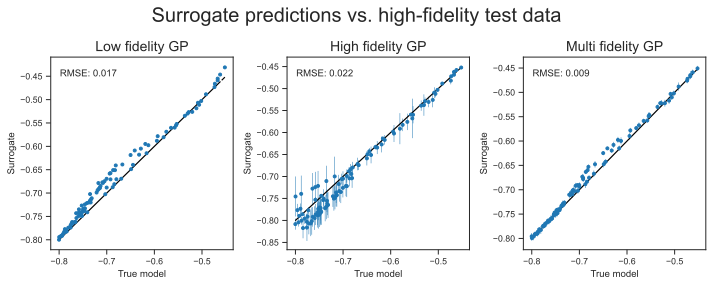

In [109]:
sample_low_fidelity_gp_cyl = partial(sample_vanilla_gp, posterior=posterior_low_cyl, D=D_low_cyl)
sample_high_fidelity_gp_cyl = partial(sample_vanilla_gp, posterior=posterior_high_cyl, D=D_high_cyl)
sample_multi_fidelity_gp_cyl = partial(sample_multi_fidelity_gp, posterior_low=posterior_low_cyl, posterior_multi=posterior_multi_cyl, D_low=D_low_cyl, D_multi=D_multi_cyl)

num_samples_cyl = 10
_ind_test_cyl = np.random.choice(ground_truth.index, 100, replace=False)
X_test_cyl = ground_truth[['x1', 'x2']].values[_ind_test_cyl]
y_test_cyl = ground_truth['y'].values[:, None][_ind_test_cyl]
key, key_low_cyl, key_high_cyl, key_multi_cyl = jrandom.split(key, 4)
samples_low_cyl = sample_low_fidelity_gp_cyl(X_test_cyl, key_low_cyl, num_samples_cyl)
samples_high_cyl = sample_high_fidelity_gp_cyl(X_test_cyl, key_high_cyl, num_samples_cyl)
samples_multi_cyl = sample_multi_fidelity_gp_cyl(X_test_cyl, key_multi_cyl, num_samples_cyl)

mean_low_test_cyl = samples_low_cyl.mean(axis=0)
std_low_test_cyl = samples_low_cyl.std(axis=0)
mean_high_test_cyl = samples_high_cyl.mean(axis=0)
std_high_test_cyl = samples_high_cyl.std(axis=0)
mean_multi_test_cyl = samples_multi_cyl.mean(axis=0)
std_multi_test_cyl = samples_multi_cyl.std(axis=0)

# Parity plot - add uncertainty on predictions using whiskers
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)
fig.suptitle("Surrogate predictions vs. high-fidelity test data", fontsize=20)
ax[0].errorbar(y_test_cyl, mean_low_test_cyl, yerr=2 * std_low_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[0].plot(y_test_cyl, y_test_cyl, "k--")
ax[0].set_xlabel("True model")
ax[0].set_ylabel("Surrogate")
ax[0].set_title("Low fidelity GP", fontsize=14)
ax[0].annotate(f"RMSE: {rmse(y_test_cyl.squeeze(-1), mean_low_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[1].errorbar(y_test_cyl, mean_high_test_cyl, yerr=2 * std_high_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[1].plot(y_test_cyl, y_test_cyl, "k--")
ax[1].set_xlabel("True model")
ax[1].set_ylabel("Surrogate")
ax[1].set_title("High fidelity GP", fontsize=14)
ax[1].annotate(f"RMSE: {rmse(y_test_cyl.squeeze(-1), mean_high_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')

ax[2].errorbar(y_test_cyl, mean_multi_test_cyl, yerr=2 * std_multi_test_cyl, fmt="o", markersize=3, lw=0.5)
ax[2].plot(y_test_cyl, y_test_cyl, "k--")
ax[2].set_xlabel("True model")
ax[2].set_ylabel("Surrogate")
ax[2].set_title("Multi fidelity GP", fontsize=14)
ax[2].annotate(f"RMSE: {rmse(y_test_cyl.squeeze(-1), mean_multi_test_cyl):.3f}", xy=(0.05, 0.9), xycoords='axes fraction');

The multi-fidelity GP has the best predictive accuracy. Let's visualize the response surface of the surrogate vs. the true high-fidelity model:

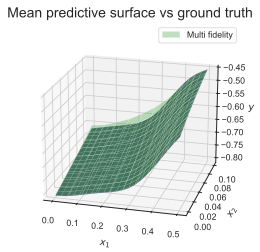

In [113]:
# Surface plot
x1_cyl, x2_cyl = jnp.linspace(ground_truth['x1'].min(), ground_truth['x1'].max(), 10), jnp.linspace(ground_truth['x2'].min(), ground_truth['x2'].max(), 10)
X1_cyl, X2_cyl = jnp.meshgrid(x1_cyl, x2_cyl)
X_plt_cyl = jnp.stack([X1_cyl.ravel(), X2_cyl.ravel()], axis=-1)
Y_high_plt_cyl = vmap(high_fidelity_model)(X_plt_cyl).reshape(X1_cyl.shape)
num_samples_cyl = 15

key, key_cyl = jrandom.split(key)
# TODO: Figure out why sampling is so slow!
mean_multi_plt_cyl = sample_multi_fidelity_gp_cyl(X_plt_cyl, key_cyl, num_samples_cyl).mean(axis=0).reshape(X1_cyl.shape)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gt[:,:,0], gt[:,:,1], gt[:,:,2], lw=0.1, color='tab:blue', alpha=0.7)
ax.plot_surface(X1_cyl, X2_cyl, mean_multi_plt_cyl, label='Multi fidelity', color='tab:green', lw=0.1, alpha=0.3)
ax.view_init(elev=20, azim=-75)
ax.set_title('Mean predictive surface vs ground truth', fontsize=14)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.legend();

The surfaces are almost right on top of each other.